In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import random
import numpy as np
import pandas as pd

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

from torch.utils.data import Dataset, DataLoader

import json
import glob
import itertools
from os.path import basename
from collections import *
from tqdm.notebook import tqdm
import networkx as nx
import random
import pickle
import tensorflow as tf
from collections import Counter
from tensorboardX import SummaryWriter

from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging

import sklearn

from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from ast import literal_eval

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [39]:
df = pd.read_csv('../../data/regression/good_condolence.csv')

In [14]:
df.head()

,id,subreddit,link_id,body,score,created_utc,author,length,filtered_link_id,hour,...,t_advice,t_school,t_advice2,ling_align,liwc_first_person,liwc_second_person,liwc_third_person,good_condolence,empathy_score,buechel_pred
0,ds0ntyd,hockey,t3_7nb6hd,Hey man it happens to everyone. It’s tough whe...,3,2017-12-31 19:15:24-05:00,ThatLineOfTriplets,71,dummy,19,...,0.001196,0.003966,0.004395,0.107692,3,3,0,False,1.318736,3.056297
1,ds0nwsq,depression,t3_7nbpv9,I know exactly what you mean. It’s the same wi...,1,2017-12-31 19:17:00-05:00,Flowerfore,88,dummy,19,...,0.001248,0.004137,0.004585,0.357143,6,7,0,False,1.466414,3.058555
2,ds0oecs,TryingForABaby,t3_7nbxzf,I'm so sorry about your father.,4,2017-12-31 19:26:54-05:00,wedditer,6,dummy,19,...,0.009362,0.356140,0.359499,0.375000,1,1,0,True,1.171976,2.429086
3,ds0oizd,TryingForABaby,t3_7nbxzf,I’m really sorry about your dad. I had a shitt...,9,2017-12-31 19:29:27-05:00,Nouveau_Depart,76,dummy,19,...,0.000898,0.002977,0.065651,0.253968,6,2,0,False,1.462780,2.945638
4,ds0okxk,raisedbynarcissists,t3_7nb7hl,I'm so sorry for you I wish I could help you i...,2,2017-12-31 19:30:32-05:00,jaact,15,dummy,19,...,0.009362,0.031039,0.359499,0.333333,3,2,0,False,1.239284,2.447037


In [78]:
df2 = pd.read_csv('../../data/empathy_regression_inputs.csv')

In [79]:
df2.head()

,id,subreddit,link_id,observer,target,good_condolence
0,e5t56vg,bayarea,t3_9ez8pq,**FUCK I'M SO SORRY**,MY GIRLFRIEND DUMPED ME ON MY BIRTHDAY VIA TEX...,False
1,e0qo6l7,MechanicAdvice,t3_8rebe6,Sorry to hear bro. I did a job and forgot to ...,I didn't torque my lug nuts properly after I r...,False
2,e4k58xo,Agoraphobia,t3_990s5i,Don’t forget to take care of yourself. That’s ...,You're right. I wish i knew how it felt. I wis...,False
3,e9g2v8k,BABYMETAL,t3_9vq48i,Don't come to mine. My daughter has the USB wi...,"I don't know if I could take NR, NR at a funer...",False
4,e9tub0x,AskReddit,t3_9xkeuc,iLaughed. I'm so so sorry.,"My parents told me at a restaurant, where they...",False


In [80]:
id_to_target = {}
for i, row in df2.iterrows():
    id_to_target[row['id']] = row['target']
df['target'] = df['id'].apply(lambda x: id_to_target[x])

In [81]:
df['text_a'] = df['target']
df['text_b'] = df['body']

In [82]:
#model_file = '/shared/0/projects/condolence/working-dir/empathy-classifier-no-ftlm-only-reply-1234/checkpoint-2000-epoch-20/'
model_file = '/shared/0/projects/condolence/working-dir/empathy-classifier-no-ftlm-1234/checkpoint-2000-epoch-20/'

# Create a ClassificationModel
model = ClassificationModel('roberta', model_file, num_labels=1, 
                            use_cuda=True, cuda_device=4, args=train_args)
#print(train_df.head())

In [83]:
toy_unlabeled_data = [["", 
                       "Yes, but wouldn't that block the screen?"]]
predictions, raw_outputs = model.predict(toy_unlabeled_data)
print(predictions)
print(raw_outputs)


1.0981085
1.0981085


In [84]:
to_predict_data = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    to_predict_data.append([row['target'], row['body']])

In [85]:
len(to_predict_data)

173293

In [86]:
predictions, raw_outputs = model.predict(to_predict_data)

In [87]:
df['roberta_empathy'] = raw_outputs

In [88]:
df['roberta_empathy_bin'] = df['roberta_empathy'].apply(lambda x: 1 if x >= 2 else 0)

In [89]:
df.to_csv('../../data/regression/good_condolence.roberta-scored.csv', index=False)

In [90]:
df['roberta_empathy'].corr(df['buechel_pred'])

0.3428793121330908

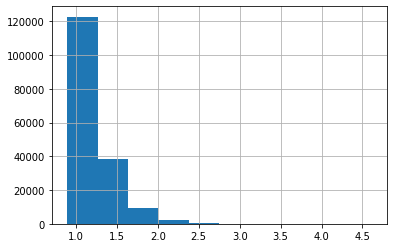

In [91]:
df['roberta_empathy'].hist()

In [92]:
len(df[df['roberta_empathy'] >= 2]['body'])

2834

In [96]:
for i, row in df[df['roberta_empathy'] >= 2].sample(100).iterrows():
    #print(str(row['roberta_empathy']) + '\t' + row['body'] + '\n')
    print(' '.join(row['body'].split()) + '\n')    

You're right in the middle of it, you're still going to be hardcore processing whatever is going on, and one way or another, people find peace with things mostly when they are set in stone. There's just so many unknowns in play right now, being apprehensive isn't strange. Leading up to treatment I was really nervous (though sex was better, because it had been stripped of all the procreative pressure) but during treatment I actually felt better, because you're actively doing something. I felt more in control then.

It really is terrible what you've been through, but that does not mean your lofe has to keep being terrible. You made the right choice choosing to cut all ties and never second guess yourself on that. Feeling guilty only shows how much of a better person you are, as they cannot even begin to understand that emotion truly. \n\nAny parent that can calmly accept the rape and attempted rape of two of their own children (by their own child no less) can not even be called parents i